In [2]:

# #############################
# ########## IMPORTS ##########
# #############################


from pyspecter.SPECTER import SPECTER
from pyshaper.Shaper import Shaper

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles, random_triangles, kT_N

from rikabplotlib.plot_utils import newplot, hist_with_errors, hist_with_outline, plot_event


# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import os

# Necessary GPU nonsense for SHAPER
import torch 
if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 


# ########## PARAMETERS ##########

N_trials = 5
R = 1
beta = 2

def generate_unit_disk(N_batch, N_particles, R=1):

    r = np.random.rand(N_batch, N_particles)
    theta = np.random.rand(N_batch, N_particles) * 2 * np.pi
    x = np.sqrt(r) * np.cos(theta) * R / 3 - 3*R/8
    y = np.sqrt(r) * np.sin(theta) * R / 3 + R/8

    weights = np.exp(-3 * np.random.rand(N_batch, N_particles))
    weights /= np.sum(weights, axis=1)[:, None]

    events = np.stack([weights, x, y], axis=-1)

    return events

def generate_gaussian(N_batch, N_particles, R=1):
 
    x = np.random.randn(N_batch, N_particles//2) * R/6 + np.random.choice([-R/2, R/2], size=(N_batch, N_particles//2))
    y = np.random.randn(N_batch, N_particles//2) * R/6

    weights = np.exp(-2 * np.random.rand(N_batch, N_particles//2))
    weights /= np.sum(weights, axis=1)[:, None]

    events = np.stack([weights, x, y], axis=-1)

    return events





2024-02-27 00:45:32.991161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Using CPU!


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


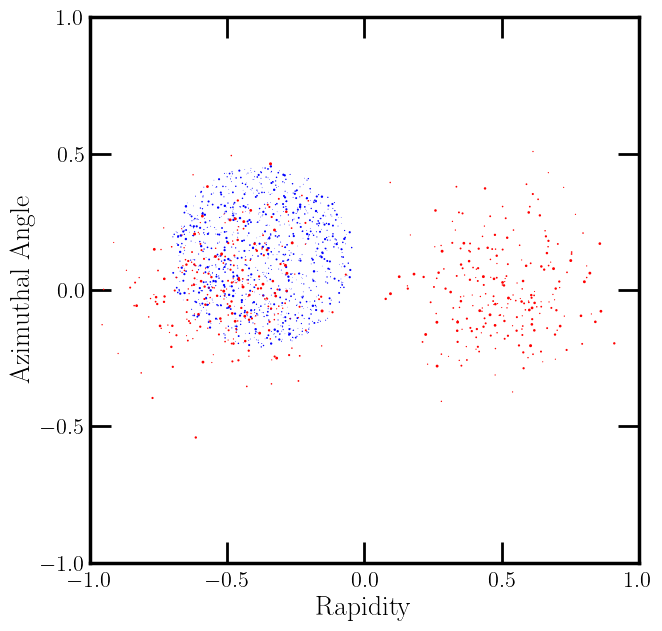

In [3]:
disk = generate_unit_disk(1, 1000, R)
gaussian = generate_gaussian(1, 1000, R )

fig, ax = newplot("full")
plot_event(ax, disk[0], color="blue", R = R)
plot_event(ax, gaussian[0], color="red", R = R)

In [4]:
def test_SPECTER_times(N_trials, N_batch, N_particles, R, beta, run_name):

    times = []

    specter = SPECTER(compile = True)


    for i in range(N_trials):
        dataset_1 = generate_unit_disk(N_batch, N_particles, R)
        dataset_2 = generate_gaussian(N_batch, N_particles, R/3)
        start = time.time()
        specter_emds = specter.spectralEMD(dataset_1, dataset_2)
        end = time.time()
        times.append(end - start)

    times = np.array(times)
    print(f"Average time for {N_trials} trials with {N_batch} batches and {N_particles} particles: {np.mean(times)}")
    np.save(f"/home/rikab/Documents/Research/SPECTER/Studies/Timing/Data/SPECTER_{N_trials}_{N_batch}_{N_particles}_{run_name}_times.npy", times)


    return times

Batch size: 1, fit: [  1.5022114  -12.25592687]
Batch size: 10, fit: [  1.80550728 -11.70915913]
Batch size: 100, fit: [  2.05887732 -10.77160267]
Batch size: 1, fit: [ 0.54548251 -5.47665973]
Batch size: 10, fit: [ 0.92693899 -5.85690341]
Batch size: 100, fit: [ 1.32136868 -5.80166161]
Batch size: 1, fit: [  0.91753743 -10.33246284]
Batch size: 10, fit: [ 0.91903117 -8.06124446]
Batch size: 100, fit: [ 0.92206053 -5.76881167]


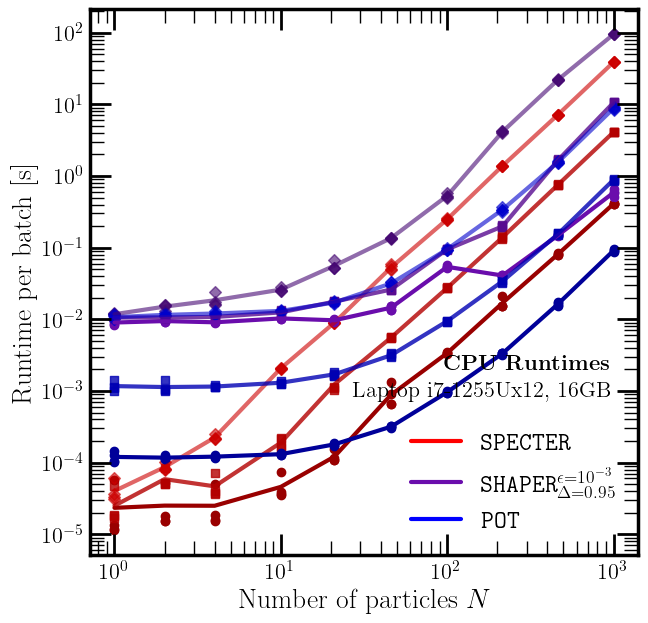

In [7]:
fig, ax = newplot("full")

run_name = "cpu"
batch_sizes = [1,10, 100]
SPECTER_colors = [(1,0,0), (0.9,0,0), (0.8,0,0), (0.7,0,0), (0.6,0,0)][::-1]
POT_colors = [(0,0,1), (0,0,0.9), (0,0,0.8), (0,0,0.7), (0,0,0.6)][::-1]
# Shades of violet
purple = np.array((106, 13, 173)) / 256
SHAPER_colors = [purple * (1 - i / (2 * len(batch_sizes))) for i in range(len(batch_sizes))]



alphas = [1, 0.8, 0.6, 0.4, 0.2]
markers = ["o", "s", "D", "P", "X"]

num_particles = np.logspace(0, 3, 10, dtype=int)


def plot_series(model, run_name, colors):
    for batch_size in batch_sizes:


        mean_times = []

        for N_particles in num_particles:

            file =  f"/home/rikab/Documents/Research/SPECTER/Studies/Timing/Data/{model}_{N_trials}_{batch_size}_{N_particles}_{run_name}_times.npy"

            try:
                times = np.load(file)
                plt.scatter(N_particles * np.ones_like(times[1:]), times[1:], color=colors[batch_sizes.index(batch_size)], alpha = alphas[batch_sizes.index(batch_size)], marker=markers[batch_sizes.index(batch_size)])
                mean_times.append(np.mean(times[1:]))
            except:
                print(f"File {file} not found")

        mean_times = np.array(mean_times)
        plt.plot(num_particles[:mean_times.shape[0]], mean_times, color=colors[batch_sizes.index(batch_size)], alpha = alphas[batch_sizes.index(batch_size)])

        # # Big X for the last point in SHAPER
        # if model == "SHAPER":
        #     plt.scatter((num_particles[:mean_times.shape[0]])[-1], mean_times[-1], color="black", alpha = alphas[batch_sizes.index(batch_size)], marker="X", s=250, lw = 2)


        # Fit to power law

        try:
            log_N = np.log(num_particles[:mean_times.shape[0]])
            log_t = np.log(mean_times)
            fit = np.polyfit(log_N, log_t, 1)
            print(f"Batch size: {batch_size}, fit: {fit}")

            

            # plt.text(num_particles[4], mean_times[4] * 2, r"Batch Size %d, $\sim N^{%.2f}$" % (batch_size, fit[0]), color=colors[batch_sizes.index(batch_size)], rotation=50, fontsize=14, ha="center", va = "center")


        except:
            print(f"Batch size: {batch_size}, fit: None")



plot_series("SPECTER", "cpu", SPECTER_colors)
plot_series("SHAPER", "cpu", SHAPER_colors)
plot_series("POT", "cpu", POT_colors)




plt.xscale("log")
plt.yscale("log")

# Dummy curves for legend
plt.plot(0,0, color=(1,0,0), label=r"\texttt{SPECTER}")
plt.plot(0,0, color=purple, label=r"$\texttt{SHAPER}^{\epsilon = 10^{-3}}_{\Delta = 0.95}$")
plt.plot(0,0, color=(0,0,1), label=r"$\texttt{POT}$")

plt.legend(fontsize=18, loc = "lower right")

# Text
plt.text(0.95, 0.35, r"\textbf{CPU Runtimes}", ha = "right", va = "center", transform = ax.transAxes)
plt.text(0.95, 0.30, r"Laptop i7-1255Ux12, 16GB", ha = "right", va = "center", transform = ax.transAxes)

plt.xlabel("Number of particles $N$")
plt.ylabel("Runtime per batch [s]")

plt.savefig("/home/rikab/Documents/Research/SPECTER/Studies/Timing/Figures/CPU_runtimes.pdf")